In [45]:
# Version 7.0

import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [46]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):  # self + other
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __radd__(self, other):  # other + self
        return self + other
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)
        
    def __rsub__(self, other):  # other - self
        return other + (-self)
    
    def __mul__(self, other):  # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # self = Value, other = int/float  # other / self
        return other * self.data ** -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad

        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError("Supporting int and float powers only for now :(")
        out = Value(self.data ** other, (self, ), f'** {other}' )

        def _backward():
            self.grad += (other * (self.data ** (other - 1.0))) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build_topo(child)
                topo.append(root)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [47]:
### DRAW THE FUNCTION GRAPH

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    nodes.add(root)
    def build(root):
        for child in root._prev:
            nodes.add(child)
            edges.add((child, root))
            build(child)
    
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: Draw the graph from left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(uid, "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(uid+n._op, n._op)
            dot.edge(uid+n._op, uid)

    for e in edges:
        dot.edge(str(id(e[0])), str(id(e[1]))+e[1]._op)

    return dot
    #dot.view()

In [48]:
# Inputs
x1 = Value(2.0); x1.label = 'x1'
x2 = Value(0.0); x2.label = 'x2'

# Weights
w1 = Value(-3.0); w1.label = 'w1'
w2 = Value(1.0); w2.label = 'w2'

# Bias
b = Value(6.8813735870195432); b.label = 'b'

# o = x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 - x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' 

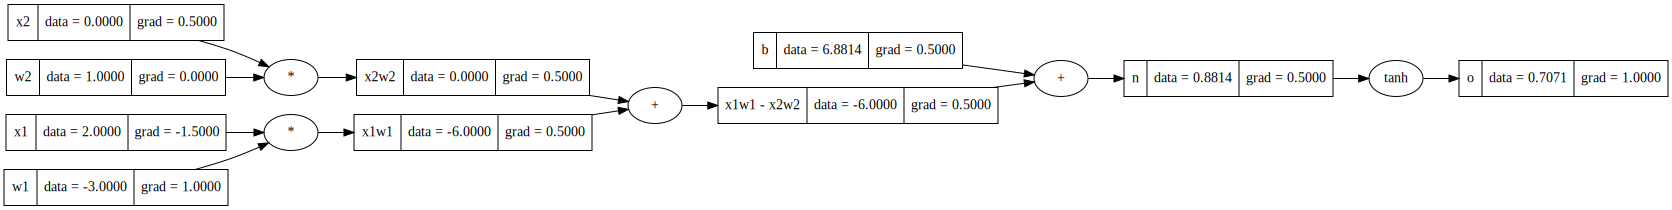

In [49]:
o.backward()
draw_graph(o)

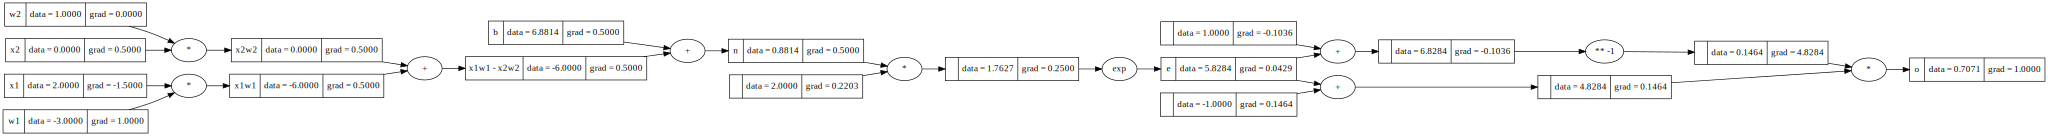

In [50]:
# Inputs
x1 = Value(2.0); x1.label = 'x1'
x2 = Value(0.0); x2.label = 'x2'

# Weights
w1 = Value(-3.0); w1.label = 'w1'
w2 = Value(1.0); w2.label = 'w2'

# Bias
b = Value(6.8813735870195432); b.label = 'b'

# o = x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 - x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#------ tanh() equivalent ------#
e = (2 * n).exp(); e.label = 'e'
o = (e-1) / (e+1)
#------                   ------#

o.label = 'o'
o.backward()
draw_graph(o)

In [51]:
#import torch

In [52]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        #print(f'{act = } {out = }')
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):  # nouts - list of neurons on each layers
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [53]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# ypred = [n(x) for x in xs]
# loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])  # ygt = y ground truth
# loss.backward()

In [54]:
# My Optimization

stepSize = 0.01
threshold = 0.001
weights = n.parameters()

for r in range(10000):
    if(loss.data < threshold):
        print(f'{r = }')
        break
    
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])  # ygt = y ground truth
    
    # Baclward pass
    loss.backward()

    # Update
    for i, _ in enumerate(weights):
        weights[i].data += -stepSize * weights[i].grad
        weights[i].grad = 0.0 # zerograd

    print(f'{r = } {loss = }')
    #print(f'{weights. = }')

r = 0 loss = Value(data=6.621939802733804)
r = 1 loss = Value(data=6.216109127553368)
r = 2 loss = Value(data=5.499444735452172)
r = 3 loss = Value(data=4.154954337105339)
r = 4 loss = Value(data=2.392969682137756)
r = 5 loss = Value(data=1.4309895324004747)
r = 6 loss = Value(data=1.0080585871200762)
r = 7 loss = Value(data=0.7880719237196578)
r = 8 loss = Value(data=0.6575214264961387)
r = 9 loss = Value(data=0.571228863491122)
r = 10 loss = Value(data=0.5090528965180331)
r = 11 loss = Value(data=0.4611949873043165)
r = 12 loss = Value(data=0.42252641492470494)
r = 13 loss = Value(data=0.39018088191967526)
r = 14 loss = Value(data=0.3624540719883479)
r = 15 loss = Value(data=0.3382700262040935)
r = 16 loss = Value(data=0.31690950640952165)
r = 17 loss = Value(data=0.2978657530417905)
r = 18 loss = Value(data=0.28076482665408653)
r = 19 loss = Value(data=0.2653198895759205)
r = 20 loss = Value(data=0.2513039196201603)
r = 21 loss = Value(data=0.2385327562013747)
r = 22 loss = Value(da

In [55]:
ypred

[Value(data=0.9848653705190968),
 Value(data=-0.9842857177834479),
 Value(data=-0.9854370944380743),
 Value(data=0.9823388368920654)]